In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import string
import random
import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.model_selection import train_test_split

SOS_token = 0
EOS_token = 1

In [3]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [4]:
class Data:
    def __init__(self):
        self.word2index = {"[SOS]":0, "[EOS]":1}
        self.word2count = {}
        self.index2word = {0: "[SOS]", 1: "[EOS]"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
MAX_LENGTH = 50
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]
    
def prepareData(input_data_path, num_samples=10000):
    with  open(input_data_path, 'r', encoding='utf-8') as f:
        input_lines = f.read().split('\n')  # 行ごとのリストに
    print("Counting words:")
    data = Data()
    target_lines = []
    for line in input_lines:
        input_words = line.split(" ")
        target_words = input_words[1:]
        target_words.append("[EOS]")
        target_lines.append(" ".join(target_words))
        data.addSentence(line)
    min_samples = min(num_samples, min(len(input_lines)-1, len(target_lines)-1))
    pairs = [[i,t]for (i,t) in zip(input_lines[:min_samples],target_lines[:min_samples])]
    pairs.append(input_lines)
    pairs.append(target_lines)
    pairs = filterPairs(pairs)

    print("Counted words:")
    print('data:{}'.format(data.n_words))
    return data, pairs

In [6]:
input_data_path = "./data/text/processed/merged_normal.txt"
#input_data_path = "./data/text/mai2000a_normal.txt"
data, pairs = prepareData(input_data_path, 30000000)
print(len(pairs))
print(random.choice(pairs))

Counting words:
Counted words:
data:410186
2915590
['さらに  「  僧りょ  に  なり  たい  」  と  希望  する  人  は  ３  年  目  以降  、  寺院  で  研修  し  て  もらう  。  ', ' 「  僧りょ  に  なり  たい  」  と  希望  する  人  は  ３  年  目  以降  、  寺院  で  研修  し  て  もらう  。   [EOS]']


In [7]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim):
        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.embeds = nn.Embedding(input_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, input_dim)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        self.hidden = self.initHidden()

    def forward(self, input, hidden):
        embeds = self.embeds(input)
        lstm_out, hidden = self.lstm(
            embeds.view(len(input), 1, -1), hidden)
        output = self.linear(lstm_out.view(len(input), -1))
        output = self.dropout(output)
        output = self.softmax(output)
        #self.hidden = hidden
        return output, hidden

    def initHidden(self):
        return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)).cuda(),
                autograd.Variable(torch.zeros(1, 1, self.hidden_dim)).cuda())

In [8]:
def indexesFromSentence(data, sentence):
    return [data.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(data, sentence):
    indexes = indexesFromSentence(data, sentence)
    #indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(data, pair[0])
    target_tensor = tensorFromSentence(data, pair[1])
    return (input_tensor, target_tensor)

In [9]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, model, optimizer, criterion, max_length=MAX_LENGTH):
    hidden = model.initHidden()
    optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    loss = 0

    for i in range(input_length):
        output, hidden = model(input_tensor[i], hidden)
        loss += criterion(output, target_tensor[i])
    loss.backward()

    optimizer.step()
    return loss.item() / target_length

In [10]:
def trainIters(model, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        input_tensor = input_tensor.cuda()
        target_tensor = target_tensor.cuda()
        loss = train(input_tensor, target_tensor, model, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [23]:
import matplotlib.pyplot as plt
plt.switch_backend('Agg')
import matplotlib.ticker as ticker
import numpy as np
plt.style.use('ggplot')

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.savefig("./results/figure.png")

In [17]:
def evaluate(model, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(data, sentence)
        input_length = input_tensor.size()[0]
        hidden = model.initHidden()
        outputs = []
        for i in range(input_length):
            output, hidden = model(input_tensor[i], hidden)
            outputs.append(output)
        return outputs

In [18]:
def evaluateRandomly(model, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        outputs = evaluate(model, pair[0])
        input_words = pair[0].split()
        for j, output in enumerate(outputs):
            if len(input_words) <= j: 
                break
            topv_list, topi_list = output[0].topk(5)
            print(input_words[j] + ":")
            output_words = []
            for index in topi_list:
                output_words.append(data.index2word[index.item()])
                
            print(output_words)

0m 23s (- 3983m 18s) (10 0%) 10.2098
0m 26s (- 2244m 43s) (20 0%) 6.7023
0m 30s (- 1682m 54s) (30 0%) 6.0389
0m 33s (- 1406m 56s) (40 0%) 5.9164
0m 37s (- 1235m 23s) (50 0%) 5.6487
0m 40s (- 1126m 31s) (60 0%) 5.6341
0m 44s (- 1048m 51s) (70 0%) 5.0549
0m 47s (- 986m 57s) (80 0%) 5.6259
0m 51s (- 946m 2s) (90 0%) 5.2694
0m 54s (- 906m 27s) (100 0%) 4.9926
0m 57s (- 875m 42s) (110 0%) 4.9788
1m 0s (- 845m 42s) (120 0%) 4.6053
1m 4s (- 824m 18s) (130 0%) 5.0802
1m 8s (- 808m 53s) (140 0%) 4.9871
1m 11s (- 796m 56s) (150 0%) 5.1408
1m 15s (- 786m 13s) (160 0%) 4.9831
1m 19s (- 775m 52s) (170 0%) 5.0273
1m 22s (- 757m 55s) (180 0%) 4.5648
1m 25s (- 747m 2s) (190 0%) 5.2057
1m 29s (- 740m 37s) (200 0%) 4.9774
1m 32s (- 729m 10s) (210 0%) 4.6591
1m 35s (- 722m 12s) (220 0%) 4.5789
1m 38s (- 714m 11s) (230 0%) 4.8656
1m 42s (- 708m 24s) (240 0%) 5.0985
1m 45s (- 703m 26s) (250 0%) 4.4255
1m 49s (- 697m 7s) (260 0%) 4.6296
1m 52s (- 694m 20s) (270 0%) 4.8091
1m 57s (- 694m 53s) (280 0%) 4.9106

13m 30s (- 586m 37s) (2250 2%) 3.7738
13m 33s (- 586m 40s) (2260 2%) 3.7071
13m 37s (- 586m 36s) (2270 2%) 4.2239
13m 40s (- 586m 19s) (2280 2%) 4.4672
13m 45s (- 586m 41s) (2290 2%) 4.0796
13m 48s (- 586m 32s) (2300 2%) 3.9033
13m 51s (- 586m 14s) (2310 2%) 3.7045
13m 54s (- 585m 55s) (2320 2%) 4.2878
13m 58s (- 585m 59s) (2330 2%) 3.9118
14m 2s (- 585m 43s) (2340 2%) 3.8435
14m 5s (- 585m 18s) (2350 2%) 3.6767
14m 8s (- 585m 19s) (2360 2%) 4.5699
14m 12s (- 585m 6s) (2370 2%) 4.2709
14m 15s (- 584m 54s) (2380 2%) 3.8965
14m 19s (- 585m 3s) (2390 2%) 3.9641
14m 22s (- 584m 39s) (2400 2%) 4.1816
14m 26s (- 584m 41s) (2410 2%) 4.1938
14m 30s (- 584m 43s) (2420 2%) 4.3063
14m 33s (- 584m 42s) (2430 2%) 4.0401
14m 37s (- 584m 46s) (2440 2%) 3.7063
14m 40s (- 584m 6s) (2450 2%) 3.7946
14m 43s (- 583m 53s) (2460 2%) 3.9508
14m 47s (- 584m 8s) (2470 2%) 4.1957
14m 51s (- 584m 9s) (2480 2%) 3.8905
14m 54s (- 583m 57s) (2490 2%) 4.1461
14m 58s (- 583m 51s) (2500 2%) 3.9320
15m 1s (- 583m 17s) 

26m 9s (- 565m 37s) (4420 4%) 4.0991
26m 13s (- 565m 36s) (4430 4%) 4.2165
26m 16s (- 565m 37s) (4440 4%) 3.7046
26m 20s (- 565m 33s) (4450 4%) 3.6255
26m 23s (- 565m 22s) (4460 4%) 4.0103
26m 26s (- 565m 11s) (4470 4%) 3.8040
26m 30s (- 565m 4s) (4480 4%) 4.1483
26m 33s (- 565m 5s) (4490 4%) 4.2750
26m 37s (- 565m 10s) (4500 4%) 4.3319
26m 41s (- 565m 9s) (4510 4%) 4.2827
26m 44s (- 565m 3s) (4520 4%) 3.5518
26m 48s (- 565m 0s) (4530 4%) 3.9788
26m 52s (- 565m 2s) (4540 4%) 4.3781
26m 56s (- 565m 3s) (4550 4%) 4.2335
26m 59s (- 564m 50s) (4560 4%) 3.9460
27m 2s (- 564m 38s) (4570 4%) 4.4769
27m 5s (- 564m 27s) (4580 4%) 3.9116
27m 8s (- 564m 19s) (4590 4%) 3.4585
27m 11s (- 564m 3s) (4600 4%) 3.9890
27m 15s (- 563m 57s) (4610 4%) 3.6794
27m 19s (- 564m 1s) (4620 4%) 4.3226
27m 22s (- 563m 53s) (4630 4%) 3.9667
27m 26s (- 563m 54s) (4640 4%) 4.2345
27m 29s (- 563m 35s) (4650 4%) 4.1551
27m 32s (- 563m 29s) (4660 4%) 4.0866
27m 37s (- 563m 45s) (4670 4%) 3.8525
27m 40s (- 563m 38s) (468

38m 54s (- 551m 32s) (6590 6%) 4.0066
38m 58s (- 551m 31s) (6600 6%) 3.8971
39m 1s (- 551m 28s) (6610 6%) 3.8069
39m 5s (- 551m 22s) (6620 6%) 3.7641
39m 8s (- 551m 20s) (6630 6%) 4.2488
39m 12s (- 551m 15s) (6640 6%) 3.8519
39m 16s (- 551m 16s) (6650 6%) 3.6280
39m 19s (- 551m 11s) (6660 6%) 3.8571
39m 23s (- 551m 17s) (6670 6%) 3.6937
39m 27s (- 551m 10s) (6680 6%) 4.0776
39m 30s (- 551m 8s) (6690 6%) 3.9962
39m 34s (- 551m 9s) (6700 6%) 3.8174
39m 38s (- 551m 5s) (6710 6%) 3.7518
39m 41s (- 550m 54s) (6720 6%) 3.6804
39m 44s (- 550m 49s) (6730 6%) 3.8110
39m 47s (- 550m 41s) (6740 6%) 4.0565
39m 50s (- 550m 30s) (6750 6%) 3.7019
39m 54s (- 550m 24s) (6760 6%) 3.8589
39m 57s (- 550m 15s) (6770 6%) 4.1265
40m 0s (- 550m 2s) (6780 6%) 3.5030
40m 3s (- 549m 59s) (6790 6%) 3.7677
40m 7s (- 549m 53s) (6800 6%) 3.6445
40m 10s (- 549m 44s) (6810 6%) 3.8720
40m 13s (- 549m 41s) (6820 6%) 3.9937
40m 17s (- 549m 40s) (6830 6%) 4.4212
40m 20s (- 549m 30s) (6840 6%) 3.4681
40m 24s (- 549m 22s) (

51m 31s (- 536m 43s) (8760 8%) 3.9714
51m 35s (- 536m 38s) (8770 8%) 3.4287
51m 38s (- 536m 33s) (8780 8%) 3.7253
51m 41s (- 536m 25s) (8790 8%) 3.6962
51m 44s (- 536m 18s) (8800 8%) 3.9719
51m 48s (- 536m 19s) (8810 8%) 3.4797
51m 52s (- 536m 16s) (8820 8%) 4.1161
51m 55s (- 536m 12s) (8830 8%) 4.1267
51m 59s (- 536m 7s) (8840 8%) 3.9021
52m 2s (- 536m 2s) (8850 8%) 3.5562
52m 6s (- 535m 59s) (8860 8%) 4.0061
52m 9s (- 535m 51s) (8870 8%) 4.2298
52m 12s (- 535m 43s) (8880 8%) 3.8244
52m 15s (- 535m 37s) (8890 8%) 3.8418
52m 18s (- 535m 30s) (8900 8%) 3.6734
52m 22s (- 535m 24s) (8910 8%) 3.7154
52m 25s (- 535m 16s) (8920 8%) 3.7799
52m 29s (- 535m 14s) (8930 8%) 3.9377
52m 32s (- 535m 13s) (8940 8%) 4.4260
52m 36s (- 535m 7s) (8950 8%) 3.9198
52m 39s (- 535m 2s) (8960 8%) 3.6843
52m 42s (- 534m 52s) (8970 8%) 3.7163
52m 45s (- 534m 48s) (8980 8%) 3.7577
52m 49s (- 534m 49s) (8990 8%) 4.0144
52m 53s (- 534m 52s) (9000 9%) 3.8520
52m 57s (- 534m 48s) (9010 9%) 3.5429
53m 0s (- 534m 43s)

63m 58s (- 524m 2s) (10880 10%) 3.7848
64m 2s (- 523m 58s) (10890 10%) 3.6425
64m 5s (- 523m 51s) (10900 10%) 3.7153
64m 8s (- 523m 48s) (10910 10%) 3.2957
64m 11s (- 523m 42s) (10920 10%) 3.6066
64m 15s (- 523m 37s) (10930 10%) 3.9572
64m 18s (- 523m 32s) (10940 10%) 3.7234
64m 22s (- 523m 30s) (10950 10%) 3.7689
64m 26s (- 523m 30s) (10960 10%) 3.7295
64m 29s (- 523m 24s) (10970 10%) 3.6914
64m 33s (- 523m 20s) (10980 10%) 3.8818
64m 36s (- 523m 18s) (10990 10%) 3.5962
64m 40s (- 523m 16s) (11000 11%) 3.9860
64m 44s (- 523m 13s) (11010 11%) 4.1782
64m 48s (- 523m 13s) (11020 11%) 4.1978
64m 51s (- 523m 10s) (11030 11%) 4.0369
64m 55s (- 523m 6s) (11040 11%) 3.9227
64m 58s (- 523m 2s) (11050 11%) 3.9003
65m 2s (- 522m 58s) (11060 11%) 4.4003
65m 5s (- 522m 55s) (11070 11%) 3.8671
65m 9s (- 522m 56s) (11080 11%) 3.5678
65m 13s (- 522m 51s) (11090 11%) 3.6621
65m 16s (- 522m 44s) (11100 11%) 3.4747
65m 19s (- 522m 42s) (11110 11%) 3.5964
65m 23s (- 522m 38s) (11120 11%) 3.9424
65m 26s (

76m 6s (- 512m 0s) (12940 12%) 3.6205
76m 9s (- 511m 54s) (12950 12%) 4.2362
76m 13s (- 511m 52s) (12960 12%) 3.8009
76m 16s (- 511m 46s) (12970 12%) 3.5109
76m 19s (- 511m 41s) (12980 12%) 3.6170
76m 21s (- 511m 30s) (12990 12%) 3.7374
76m 25s (- 511m 27s) (13000 13%) 3.9271
76m 29s (- 511m 30s) (13010 13%) 3.7928
76m 34s (- 511m 32s) (13020 13%) 3.6948
76m 37s (- 511m 29s) (13030 13%) 3.8185
76m 40s (- 511m 22s) (13040 13%) 3.4762
76m 44s (- 511m 19s) (13050 13%) 3.8210
76m 48s (- 511m 18s) (13060 13%) 3.7919
76m 50s (- 511m 8s) (13070 13%) 3.6791
76m 54s (- 511m 6s) (13080 13%) 3.4711
76m 58s (- 511m 5s) (13090 13%) 3.6856
77m 1s (- 511m 0s) (13100 13%) 3.9829
77m 5s (- 510m 56s) (13110 13%) 3.7339
77m 9s (- 510m 56s) (13120 13%) 4.1931
77m 12s (- 510m 49s) (13130 13%) 3.7705
77m 15s (- 510m 43s) (13140 13%) 3.3481
77m 19s (- 510m 42s) (13150 13%) 3.9137
77m 23s (- 510m 39s) (13160 13%) 4.3600
77m 26s (- 510m 34s) (13170 13%) 3.8575
77m 30s (- 510m 33s) (13180 13%) 3.9151
77m 33s (-

88m 6s (- 499m 15s) (15000 15%) 3.9369
88m 9s (- 499m 11s) (15010 15%) 3.5007
88m 13s (- 499m 7s) (15020 15%) 3.7823
88m 16s (- 499m 0s) (15030 15%) 3.5959
88m 19s (- 498m 54s) (15040 15%) 3.7753
88m 22s (- 498m 50s) (15050 15%) 3.9668
88m 26s (- 498m 48s) (15060 15%) 4.1615
88m 29s (- 498m 40s) (15070 15%) 3.5575
88m 32s (- 498m 37s) (15080 15%) 3.7896
88m 35s (- 498m 32s) (15090 15%) 3.4644
88m 39s (- 498m 28s) (15100 15%) 3.7612
88m 42s (- 498m 24s) (15110 15%) 3.8900
88m 46s (- 498m 20s) (15120 15%) 3.4679
88m 49s (- 498m 15s) (15130 15%) 3.5221
88m 52s (- 498m 11s) (15140 15%) 3.7933
88m 57s (- 498m 11s) (15150 15%) 4.0824
89m 0s (- 498m 9s) (15160 15%) 3.6382
89m 4s (- 498m 8s) (15170 15%) 3.8929
89m 8s (- 498m 3s) (15180 15%) 3.7036
89m 11s (- 497m 57s) (15190 15%) 4.0028
89m 15s (- 497m 55s) (15200 15%) 3.8880
89m 18s (- 497m 51s) (15210 15%) 4.1103
89m 21s (- 497m 45s) (15220 15%) 3.6349
89m 24s (- 497m 37s) (15230 15%) 3.4986
89m 28s (- 497m 35s) (15240 15%) 3.6842
89m 31s (-

99m 55s (- 485m 46s) (17060 17%) 3.7615
99m 58s (- 485m 42s) (17070 17%) 3.8223
100m 1s (- 485m 37s) (17080 17%) 3.6752
100m 5s (- 485m 36s) (17090 17%) 3.7739
100m 9s (- 485m 34s) (17100 17%) 3.9364
100m 13s (- 485m 33s) (17110 17%) 3.7773
100m 17s (- 485m 29s) (17120 17%) 3.9097
100m 20s (- 485m 27s) (17130 17%) 3.7600
100m 24s (- 485m 22s) (17140 17%) 3.8570
100m 27s (- 485m 16s) (17150 17%) 3.4756
100m 30s (- 485m 12s) (17160 17%) 3.2301
100m 34s (- 485m 9s) (17170 17%) 3.7179
100m 37s (- 485m 4s) (17180 17%) 3.4640
100m 40s (- 485m 0s) (17190 17%) 3.3871
100m 44s (- 484m 56s) (17200 17%) 3.8141
100m 48s (- 484m 54s) (17210 17%) 3.6776
100m 51s (- 484m 53s) (17220 17%) 3.8550
100m 55s (- 484m 47s) (17230 17%) 3.6565
100m 58s (- 484m 45s) (17240 17%) 4.0345
101m 2s (- 484m 43s) (17250 17%) 3.7571
101m 6s (- 484m 39s) (17260 17%) 4.2537
101m 9s (- 484m 35s) (17270 17%) 3.6473
101m 12s (- 484m 29s) (17280 17%) 3.8229
101m 16s (- 484m 25s) (17290 17%) 3.8881
101m 20s (- 484m 24s) (1730

111m 42s (- 474m 3s) (19070 19%) 3.7388
111m 45s (- 474m 0s) (19080 19%) 3.7819
111m 49s (- 473m 55s) (19090 19%) 3.6817
111m 52s (- 473m 49s) (19100 19%) 4.1240
111m 55s (- 473m 47s) (19110 19%) 3.4718
111m 59s (- 473m 42s) (19120 19%) 3.5208
112m 2s (- 473m 39s) (19130 19%) 3.2917
112m 5s (- 473m 34s) (19140 19%) 3.6905
112m 9s (- 473m 31s) (19150 19%) 3.7341
112m 13s (- 473m 30s) (19160 19%) 3.9141
112m 16s (- 473m 25s) (19170 19%) 4.1098
112m 20s (- 473m 21s) (19180 19%) 3.9688
112m 23s (- 473m 16s) (19190 19%) 3.6475
112m 26s (- 473m 11s) (19200 19%) 4.2040
112m 30s (- 473m 8s) (19210 19%) 3.8381
112m 33s (- 473m 5s) (19220 19%) 3.9438
112m 37s (- 473m 1s) (19230 19%) 3.6936
112m 40s (- 472m 57s) (19240 19%) 3.9608
112m 44s (- 472m 54s) (19250 19%) 3.6262
112m 47s (- 472m 50s) (19260 19%) 3.2988
112m 51s (- 472m 47s) (19270 19%) 3.7048
112m 54s (- 472m 43s) (19280 19%) 3.2301
112m 58s (- 472m 40s) (19290 19%) 3.7557
113m 1s (- 472m 35s) (19300 19%) 3.7648
113m 4s (- 472m 31s) (193

123m 19s (- 461m 41s) (21080 21%) 3.5436
123m 22s (- 461m 37s) (21090 21%) 3.7206
123m 26s (- 461m 34s) (21100 21%) 3.5389
123m 29s (- 461m 30s) (21110 21%) 3.3759
123m 32s (- 461m 25s) (21120 21%) 3.6990
123m 36s (- 461m 22s) (21130 21%) 3.4819
123m 39s (- 461m 17s) (21140 21%) 3.6066
123m 43s (- 461m 13s) (21150 21%) 3.3822
123m 47s (- 461m 13s) (21160 21%) 3.9891
123m 50s (- 461m 9s) (21170 21%) 3.4586
123m 53s (- 461m 4s) (21180 21%) 3.5262
123m 57s (- 461m 2s) (21190 21%) 3.9095
124m 0s (- 460m 58s) (21200 21%) 3.5680
124m 4s (- 460m 53s) (21210 21%) 3.7963
124m 7s (- 460m 50s) (21220 21%) 3.4980
124m 11s (- 460m 47s) (21230 21%) 3.8282
124m 14s (- 460m 41s) (21240 21%) 3.5253
124m 17s (- 460m 35s) (21250 21%) 3.7130
124m 19s (- 460m 28s) (21260 21%) 3.2070
124m 23s (- 460m 24s) (21270 21%) 3.2873
124m 26s (- 460m 20s) (21280 21%) 3.7239
124m 30s (- 460m 17s) (21290 21%) 3.5243
124m 33s (- 460m 13s) (21300 21%) 4.0315
124m 37s (- 460m 11s) (21310 21%) 4.0178
124m 40s (- 460m 7s) (

135m 9s (- 450m 12s) (23090 23%) 3.6750
135m 13s (- 450m 8s) (23100 23%) 4.1110
135m 16s (- 450m 4s) (23110 23%) 3.8353
135m 19s (- 449m 59s) (23120 23%) 3.5955
135m 23s (- 449m 57s) (23130 23%) 4.0661
135m 27s (- 449m 54s) (23140 23%) 3.9168
135m 31s (- 449m 52s) (23150 23%) 3.8726
135m 34s (- 449m 47s) (23160 23%) 3.3956
135m 37s (- 449m 44s) (23170 23%) 3.6138
135m 41s (- 449m 41s) (23180 23%) 3.6425
135m 44s (- 449m 37s) (23190 23%) 3.5183
135m 48s (- 449m 35s) (23200 23%) 3.2899
135m 52s (- 449m 32s) (23210 23%) 3.9016
135m 56s (- 449m 29s) (23220 23%) 3.3388
135m 59s (- 449m 26s) (23230 23%) 3.6114
136m 3s (- 449m 23s) (23240 23%) 4.1168
136m 7s (- 449m 21s) (23250 23%) 3.9072
136m 11s (- 449m 19s) (23260 23%) 3.2502
136m 15s (- 449m 16s) (23270 23%) 4.0799
136m 19s (- 449m 15s) (23280 23%) 3.6201
136m 22s (- 449m 9s) (23290 23%) 3.0182
136m 25s (- 449m 6s) (23300 23%) 3.7723
136m 29s (- 449m 2s) (23310 23%) 3.7329
136m 32s (- 448m 59s) (23320 23%) 3.9133
136m 35s (- 448m 54s) (2

146m 58s (- 438m 33s) (25100 25%) 3.3450
147m 1s (- 438m 30s) (25110 25%) 2.9508
147m 5s (- 438m 26s) (25120 25%) 3.4283
147m 9s (- 438m 24s) (25130 25%) 3.6429
147m 12s (- 438m 21s) (25140 25%) 3.3085
147m 15s (- 438m 17s) (25150 25%) 3.8801
147m 19s (- 438m 13s) (25160 25%) 3.9954
147m 22s (- 438m 9s) (25170 25%) 3.1670
147m 26s (- 438m 6s) (25180 25%) 4.2245
147m 29s (- 438m 2s) (25190 25%) 3.8955
147m 33s (- 437m 58s) (25200 25%) 3.8809
147m 36s (- 437m 55s) (25210 25%) 3.4835
147m 40s (- 437m 52s) (25220 25%) 3.7928
147m 44s (- 437m 49s) (25230 25%) 3.9025
147m 47s (- 437m 44s) (25240 25%) 3.3949
147m 50s (- 437m 41s) (25250 25%) 3.7576
147m 54s (- 437m 38s) (25260 25%) 3.9756
147m 58s (- 437m 36s) (25270 25%) 3.7381
148m 1s (- 437m 31s) (25280 25%) 4.1963
148m 5s (- 437m 28s) (25290 25%) 3.8301
148m 8s (- 437m 24s) (25300 25%) 3.5152
148m 11s (- 437m 18s) (25310 25%) 3.4061
148m 15s (- 437m 15s) (25320 25%) 3.8014
148m 18s (- 437m 12s) (25330 25%) 3.6009
148m 22s (- 437m 8s) (253

158m 43s (- 426m 44s) (27110 27%) 3.8466
158m 46s (- 426m 40s) (27120 27%) 3.8318
158m 49s (- 426m 35s) (27130 27%) 3.4649
158m 52s (- 426m 31s) (27140 27%) 3.8016
158m 55s (- 426m 26s) (27150 27%) 3.5268
158m 59s (- 426m 25s) (27160 27%) 3.9437
159m 2s (- 426m 20s) (27170 27%) 3.0829
159m 5s (- 426m 14s) (27180 27%) 3.4068
159m 8s (- 426m 10s) (27190 27%) 3.0229
159m 12s (- 426m 7s) (27200 27%) 3.4890
159m 16s (- 426m 4s) (27210 27%) 3.3491
159m 19s (- 426m 0s) (27220 27%) 3.9582
159m 23s (- 425m 56s) (27230 27%) 4.0570
159m 27s (- 425m 54s) (27240 27%) 3.7361
159m 31s (- 425m 52s) (27250 27%) 3.8296
159m 33s (- 425m 46s) (27260 27%) 3.9005
159m 37s (- 425m 43s) (27270 27%) 3.8488
159m 41s (- 425m 40s) (27280 27%) 3.8369
159m 44s (- 425m 36s) (27290 27%) 3.6145
159m 48s (- 425m 33s) (27300 27%) 3.6211
159m 51s (- 425m 30s) (27310 27%) 3.5232
159m 55s (- 425m 27s) (27320 27%) 3.4080
159m 58s (- 425m 23s) (27330 27%) 3.8702
160m 2s (- 425m 21s) (27340 27%) 3.7042
160m 6s (- 425m 17s) (2

170m 24s (- 414m 47s) (29120 29%) 3.4613
170m 28s (- 414m 44s) (29130 29%) 3.3838
170m 31s (- 414m 40s) (29140 29%) 3.8714
170m 35s (- 414m 36s) (29150 29%) 3.8044
170m 38s (- 414m 32s) (29160 29%) 3.9925
170m 42s (- 414m 29s) (29170 29%) 3.8123
170m 45s (- 414m 25s) (29180 29%) 3.6731
170m 48s (- 414m 20s) (29190 29%) 3.3480
170m 51s (- 414m 17s) (29200 29%) 3.6304
170m 55s (- 414m 13s) (29210 29%) 3.8343
170m 58s (- 414m 9s) (29220 29%) 3.6004
171m 1s (- 414m 5s) (29230 29%) 3.5671
171m 5s (- 414m 1s) (29240 29%) 3.1876
171m 8s (- 413m 57s) (29250 29%) 3.6092
171m 12s (- 413m 54s) (29260 29%) 3.4727
171m 15s (- 413m 49s) (29270 29%) 3.4277
171m 18s (- 413m 46s) (29280 29%) 3.8797
171m 22s (- 413m 42s) (29290 29%) 4.1797
171m 25s (- 413m 39s) (29300 29%) 3.4543
171m 29s (- 413m 35s) (29310 29%) 3.7912
171m 32s (- 413m 32s) (29320 29%) 3.6145
171m 35s (- 413m 27s) (29330 29%) 3.7435
171m 39s (- 413m 24s) (29340 29%) 3.1944
171m 42s (- 413m 20s) (29350 29%) 4.0838
171m 46s (- 413m 17s) 

182m 10s (- 403m 1s) (31130 31%) 3.2688
182m 14s (- 402m 58s) (31140 31%) 3.8235
182m 17s (- 402m 55s) (31150 31%) 3.5712
182m 21s (- 402m 51s) (31160 31%) 3.5153
182m 24s (- 402m 47s) (31170 31%) 3.5749
182m 27s (- 402m 43s) (31180 31%) 3.7884
182m 30s (- 402m 39s) (31190 31%) 3.5353
182m 34s (- 402m 36s) (31200 31%) 4.0627
182m 38s (- 402m 33s) (31210 31%) 3.9661
182m 41s (- 402m 28s) (31220 31%) 3.7192
182m 44s (- 402m 25s) (31230 31%) 3.9683
182m 48s (- 402m 21s) (31240 31%) 3.6643
182m 51s (- 402m 17s) (31250 31%) 3.6894
182m 55s (- 402m 15s) (31260 31%) 3.3667
182m 59s (- 402m 11s) (31270 31%) 3.5628
183m 2s (- 402m 8s) (31280 31%) 4.0281
183m 5s (- 402m 3s) (31290 31%) 3.6537
183m 9s (- 401m 59s) (31300 31%) 3.5436
183m 12s (- 401m 55s) (31310 31%) 3.8038
183m 15s (- 401m 52s) (31320 31%) 3.7890
183m 19s (- 401m 49s) (31330 31%) 3.7373
183m 23s (- 401m 45s) (31340 31%) 3.7110
183m 26s (- 401m 42s) (31350 31%) 3.4698
183m 30s (- 401m 39s) (31360 31%) 3.4910
183m 34s (- 401m 37s) 

194m 5s (- 391m 34s) (33140 33%) 3.6726
194m 8s (- 391m 30s) (33150 33%) 3.9648
194m 12s (- 391m 27s) (33160 33%) 3.1713
194m 15s (- 391m 24s) (33170 33%) 3.4555
194m 19s (- 391m 20s) (33180 33%) 3.6627
194m 23s (- 391m 17s) (33190 33%) 3.4840
194m 27s (- 391m 15s) (33200 33%) 3.9410
194m 30s (- 391m 10s) (33210 33%) 3.3826
194m 34s (- 391m 7s) (33220 33%) 3.5384
194m 37s (- 391m 3s) (33230 33%) 3.6265
194m 40s (- 390m 59s) (33240 33%) 3.4647
194m 43s (- 390m 55s) (33250 33%) 3.5254
194m 47s (- 390m 53s) (33260 33%) 3.9511
194m 51s (- 390m 50s) (33270 33%) 3.8913
194m 55s (- 390m 47s) (33280 33%) 4.0781
194m 59s (- 390m 44s) (33290 33%) 3.9150
195m 2s (- 390m 40s) (33300 33%) 3.2431
195m 5s (- 390m 35s) (33310 33%) 3.6924
195m 9s (- 390m 32s) (33320 33%) 4.0292
195m 12s (- 390m 28s) (33330 33%) 3.8009
195m 15s (- 390m 24s) (33340 33%) 3.2957
195m 19s (- 390m 21s) (33350 33%) 4.0998
195m 22s (- 390m 17s) (33360 33%) 3.7009
195m 25s (- 390m 13s) (33370 33%) 3.4542
195m 28s (- 390m 8s) (3

205m 56s (- 379m 56s) (35150 35%) 4.1439
205m 59s (- 379m 52s) (35160 35%) 3.4949
206m 3s (- 379m 49s) (35170 35%) 3.6856
206m 6s (- 379m 46s) (35180 35%) 3.0827
206m 10s (- 379m 43s) (35190 35%) 3.2321
206m 14s (- 379m 39s) (35200 35%) 3.8251
206m 17s (- 379m 35s) (35210 35%) 3.9161
206m 20s (- 379m 32s) (35220 35%) 3.8540
206m 24s (- 379m 28s) (35230 35%) 3.5813
206m 27s (- 379m 24s) (35240 35%) 3.5760
206m 30s (- 379m 19s) (35250 35%) 3.3122
206m 33s (- 379m 15s) (35260 35%) 3.2424
206m 37s (- 379m 12s) (35270 35%) 3.6592
206m 41s (- 379m 9s) (35280 35%) 3.6648
206m 44s (- 379m 6s) (35290 35%) 3.5933
206m 48s (- 379m 3s) (35300 35%) 3.9228
206m 52s (- 379m 0s) (35310 35%) 3.4644
206m 56s (- 378m 57s) (35320 35%) 4.1075
207m 0s (- 378m 54s) (35330 35%) 4.1602
207m 3s (- 378m 50s) (35340 35%) 3.3344
207m 6s (- 378m 46s) (35350 35%) 3.5128
207m 10s (- 378m 43s) (35360 35%) 3.3184
207m 14s (- 378m 40s) (35370 35%) 3.6398
207m 17s (- 378m 36s) (35380 35%) 3.8790
207m 21s (- 378m 33s) (35

217m 54s (- 368m 29s) (37160 37%) 3.5344
217m 58s (- 368m 27s) (37170 37%) 3.1753
218m 2s (- 368m 24s) (37180 37%) 3.6434
218m 5s (- 368m 20s) (37190 37%) 3.3817
218m 9s (- 368m 17s) (37200 37%) 3.5220
218m 13s (- 368m 14s) (37210 37%) 3.3342
218m 17s (- 368m 11s) (37220 37%) 3.6106
218m 20s (- 368m 7s) (37230 37%) 3.7439
218m 23s (- 368m 3s) (37240 37%) 3.7033
218m 27s (- 367m 59s) (37250 37%) 3.4304
218m 31s (- 367m 57s) (37260 37%) 3.8481
218m 34s (- 367m 53s) (37270 37%) 3.3376
218m 38s (- 367m 50s) (37280 37%) 3.7611
218m 42s (- 367m 47s) (37290 37%) 3.6333
218m 45s (- 367m 43s) (37300 37%) 3.5264
218m 48s (- 367m 39s) (37310 37%) 3.2465
218m 52s (- 367m 35s) (37320 37%) 3.6545
218m 56s (- 367m 32s) (37330 37%) 3.5498
218m 59s (- 367m 28s) (37340 37%) 3.1851
219m 2s (- 367m 24s) (37350 37%) 3.9291
219m 6s (- 367m 21s) (37360 37%) 3.8075
219m 10s (- 367m 18s) (37370 37%) 3.5667
219m 13s (- 367m 14s) (37380 37%) 3.5285
219m 16s (- 367m 11s) (37390 37%) 3.4838
219m 20s (- 367m 7s) (3

229m 43s (- 356m 45s) (39170 39%) 3.3894
229m 47s (- 356m 43s) (39180 39%) 3.6819
229m 50s (- 356m 39s) (39190 39%) 3.1919
229m 54s (- 356m 35s) (39200 39%) 3.5118
229m 57s (- 356m 31s) (39210 39%) 3.5413
230m 1s (- 356m 28s) (39220 39%) 3.8292
230m 5s (- 356m 25s) (39230 39%) 3.7101
230m 8s (- 356m 21s) (39240 39%) 4.0581
230m 12s (- 356m 18s) (39250 39%) 3.6541
230m 15s (- 356m 14s) (39260 39%) 3.9085
230m 18s (- 356m 10s) (39270 39%) 3.3111
230m 22s (- 356m 6s) (39280 39%) 3.7578
230m 25s (- 356m 3s) (39290 39%) 3.2834
230m 29s (- 356m 0s) (39300 39%) 3.5063
230m 33s (- 355m 57s) (39310 39%) 3.1317
230m 37s (- 355m 54s) (39320 39%) 3.7675
230m 42s (- 355m 52s) (39330 39%) 3.7956
230m 46s (- 355m 50s) (39340 39%) 3.9240
230m 49s (- 355m 46s) (39350 39%) 3.2795
230m 53s (- 355m 43s) (39360 39%) 3.5944
230m 56s (- 355m 38s) (39370 39%) 3.2138
230m 59s (- 355m 35s) (39380 39%) 3.9395
231m 3s (- 355m 31s) (39390 39%) 3.8422
231m 6s (- 355m 28s) (39400 39%) 3.3449
231m 9s (- 355m 23s) (39

241m 42s (- 345m 15s) (41180 41%) 3.5526
241m 46s (- 345m 12s) (41190 41%) 3.7716
241m 50s (- 345m 8s) (41200 41%) 3.5381
241m 53s (- 345m 5s) (41210 41%) 3.3590
241m 57s (- 345m 1s) (41220 41%) 3.9634
242m 0s (- 344m 58s) (41230 41%) 3.7961
242m 4s (- 344m 54s) (41240 41%) 4.2785
242m 7s (- 344m 50s) (41250 41%) 3.4899
242m 10s (- 344m 47s) (41260 41%) 3.5792
242m 14s (- 344m 43s) (41270 41%) 3.8695
242m 17s (- 344m 39s) (41280 41%) 3.3755
242m 20s (- 344m 35s) (41290 41%) 3.4831
242m 23s (- 344m 31s) (41300 41%) 3.6492
242m 26s (- 344m 27s) (41310 41%) 3.0596
242m 30s (- 344m 23s) (41320 41%) 3.4968
242m 34s (- 344m 20s) (41330 41%) 3.7445
242m 38s (- 344m 17s) (41340 41%) 4.1141
242m 42s (- 344m 14s) (41350 41%) 3.7864
242m 46s (- 344m 11s) (41360 41%) 3.6703
242m 49s (- 344m 8s) (41370 41%) 3.6560
242m 53s (- 344m 4s) (41380 41%) 3.2780
242m 56s (- 344m 1s) (41390 41%) 3.3566
243m 0s (- 343m 58s) (41400 41%) 3.7285
243m 4s (- 343m 55s) (41410 41%) 3.9980
243m 8s (- 343m 52s) (41420

253m 28s (- 333m 24s) (43190 43%) 3.7361
253m 31s (- 333m 20s) (43200 43%) 3.8244
253m 35s (- 333m 17s) (43210 43%) 3.7083
253m 39s (- 333m 14s) (43220 43%) 3.7701
253m 42s (- 333m 10s) (43230 43%) 3.6142
253m 46s (- 333m 7s) (43240 43%) 3.6283
253m 50s (- 333m 4s) (43250 43%) 3.8045
253m 54s (- 333m 1s) (43260 43%) 3.5271
253m 57s (- 332m 57s) (43270 43%) 3.6652
254m 0s (- 332m 53s) (43280 43%) 3.9899
254m 4s (- 332m 50s) (43290 43%) 3.4739
254m 7s (- 332m 46s) (43300 43%) 3.1839
254m 11s (- 332m 42s) (43310 43%) 3.8790
254m 14s (- 332m 38s) (43320 43%) 3.5121
254m 17s (- 332m 34s) (43330 43%) 3.2531
254m 21s (- 332m 31s) (43340 43%) 3.5927
254m 24s (- 332m 28s) (43350 43%) 3.4960
254m 28s (- 332m 24s) (43360 43%) 3.4964
254m 31s (- 332m 20s) (43370 43%) 3.8547
254m 35s (- 332m 17s) (43380 43%) 3.4147
254m 39s (- 332m 14s) (43390 43%) 3.9028
254m 42s (- 332m 11s) (43400 43%) 3.3916
254m 45s (- 332m 6s) (43410 43%) 3.7707
254m 49s (- 332m 3s) (43420 43%) 3.4596
254m 52s (- 331m 59s) (4

265m 15s (- 321m 36s) (45200 45%) 3.6762
265m 19s (- 321m 32s) (45210 45%) 3.2483
265m 22s (- 321m 28s) (45220 45%) 3.1438
265m 26s (- 321m 25s) (45230 45%) 3.4827
265m 29s (- 321m 21s) (45240 45%) 3.5296
265m 33s (- 321m 18s) (45250 45%) 3.2290
265m 37s (- 321m 15s) (45260 45%) 3.4626
265m 40s (- 321m 11s) (45270 45%) 2.9470
265m 44s (- 321m 9s) (45280 45%) 3.5822
265m 48s (- 321m 5s) (45290 45%) 3.5148
265m 52s (- 321m 2s) (45300 45%) 3.2119
265m 55s (- 320m 58s) (45310 45%) 3.9175
265m 58s (- 320m 55s) (45320 45%) 3.7135
266m 2s (- 320m 51s) (45330 45%) 3.8769
266m 6s (- 320m 48s) (45340 45%) 3.5945
266m 9s (- 320m 44s) (45350 45%) 3.1983
266m 13s (- 320m 41s) (45360 45%) 3.2854
266m 16s (- 320m 37s) (45370 45%) 3.0720
266m 20s (- 320m 34s) (45380 45%) 3.2397
266m 23s (- 320m 30s) (45390 45%) 3.3128
266m 27s (- 320m 27s) (45400 45%) 3.8435
266m 31s (- 320m 24s) (45410 45%) 3.4803
266m 34s (- 320m 20s) (45420 45%) 3.4350
266m 37s (- 320m 16s) (45430 45%) 4.0526
266m 41s (- 320m 12s) 

277m 6s (- 309m 51s) (47210 47%) 4.1071
277m 9s (- 309m 47s) (47220 47%) 3.3539
277m 13s (- 309m 44s) (47230 47%) 4.1930
277m 17s (- 309m 41s) (47240 47%) 3.4144
277m 20s (- 309m 37s) (47250 47%) 3.2657
277m 24s (- 309m 34s) (47260 47%) 3.6185
277m 27s (- 309m 30s) (47270 47%) 3.8110
277m 31s (- 309m 27s) (47280 47%) 3.3294
277m 35s (- 309m 24s) (47290 47%) 3.7694
277m 38s (- 309m 20s) (47300 47%) 3.6546
277m 42s (- 309m 17s) (47310 47%) 3.4106
277m 45s (- 309m 13s) (47320 47%) 4.4430
277m 49s (- 309m 10s) (47330 47%) 3.6398
277m 53s (- 309m 6s) (47340 47%) 3.3648
277m 56s (- 309m 3s) (47350 47%) 3.5513
278m 0s (- 309m 0s) (47360 47%) 3.6667
278m 4s (- 308m 56s) (47370 47%) 3.4220
278m 8s (- 308m 54s) (47380 47%) 3.2822
278m 12s (- 308m 50s) (47390 47%) 3.2992
278m 15s (- 308m 46s) (47400 47%) 3.7612
278m 19s (- 308m 43s) (47410 47%) 3.3962
278m 23s (- 308m 40s) (47420 47%) 3.4848
278m 26s (- 308m 36s) (47430 47%) 3.7787
278m 30s (- 308m 33s) (47440 47%) 3.5938
278m 34s (- 308m 30s) (4

289m 2s (- 298m 12s) (49220 49%) 3.3445
289m 5s (- 298m 8s) (49230 49%) 3.6857
289m 9s (- 298m 5s) (49240 49%) 3.7071
289m 13s (- 298m 1s) (49250 49%) 3.3910
289m 15s (- 297m 57s) (49260 49%) 3.0942
289m 19s (- 297m 53s) (49270 49%) 2.9566
289m 22s (- 297m 49s) (49280 49%) 3.9460
289m 25s (- 297m 45s) (49290 49%) 3.1851
289m 28s (- 297m 41s) (49300 49%) 3.3510
289m 31s (- 297m 38s) (49310 49%) 3.7575
289m 35s (- 297m 34s) (49320 49%) 2.9644
289m 38s (- 297m 30s) (49330 49%) 3.5380
289m 41s (- 297m 26s) (49340 49%) 3.9982
289m 44s (- 297m 22s) (49350 49%) 3.4435
289m 48s (- 297m 19s) (49360 49%) 3.8957
289m 51s (- 297m 14s) (49370 49%) 3.6896
289m 54s (- 297m 11s) (49380 49%) 3.6184
289m 58s (- 297m 8s) (49390 49%) 3.7856
290m 1s (- 297m 4s) (49400 49%) 3.6853
290m 5s (- 297m 1s) (49410 49%) 3.4996
290m 8s (- 296m 57s) (49420 49%) 3.4858
290m 11s (- 296m 53s) (49430 49%) 3.2122
290m 15s (- 296m 50s) (49440 49%) 3.8747
290m 18s (- 296m 46s) (49450 49%) 3.2276
290m 22s (- 296m 42s) (49460

300m 52s (- 286m 25s) (51230 51%) 3.8226
300m 56s (- 286m 22s) (51240 51%) 3.9434
300m 59s (- 286m 19s) (51250 51%) 3.7387
301m 3s (- 286m 15s) (51260 51%) 3.7791
301m 6s (- 286m 11s) (51270 51%) 3.0766
301m 10s (- 286m 8s) (51280 51%) 3.7720
301m 14s (- 286m 4s) (51290 51%) 3.5655
301m 17s (- 286m 1s) (51300 51%) 3.1378
301m 21s (- 285m 57s) (51310 51%) 3.4874
301m 24s (- 285m 54s) (51320 51%) 3.5622
301m 27s (- 285m 50s) (51330 51%) 3.7506
301m 31s (- 285m 46s) (51340 51%) 3.8034
301m 34s (- 285m 43s) (51350 51%) 3.6810
301m 38s (- 285m 39s) (51360 51%) 3.3005
301m 41s (- 285m 35s) (51370 51%) 3.5533
301m 44s (- 285m 31s) (51380 51%) 3.5496
301m 47s (- 285m 27s) (51390 51%) 3.6937
301m 50s (- 285m 24s) (51400 51%) 3.4181
301m 53s (- 285m 20s) (51410 51%) 3.2019
301m 58s (- 285m 17s) (51420 51%) 3.5951
302m 1s (- 285m 14s) (51430 51%) 3.2124
302m 5s (- 285m 10s) (51440 51%) 3.2120
302m 8s (- 285m 6s) (51450 51%) 3.6736
302m 11s (- 285m 3s) (51460 51%) 3.4010
302m 15s (- 284m 59s) (514

312m 41s (- 274m 37s) (53240 53%) 3.7733
312m 44s (- 274m 34s) (53250 53%) 3.6404
312m 48s (- 274m 30s) (53260 53%) 3.4896
312m 51s (- 274m 26s) (53270 53%) 3.3464
312m 55s (- 274m 23s) (53280 53%) 3.7781
312m 58s (- 274m 19s) (53290 53%) 3.2859
313m 1s (- 274m 15s) (53300 53%) 3.7150
313m 5s (- 274m 12s) (53310 53%) 3.9084
313m 8s (- 274m 8s) (53320 53%) 4.1433
313m 11s (- 274m 4s) (53330 53%) 3.5655
313m 14s (- 274m 0s) (53340 53%) 3.7066
313m 18s (- 273m 57s) (53350 53%) 3.4997
313m 22s (- 273m 54s) (53360 53%) 3.9255
313m 25s (- 273m 51s) (53370 53%) 4.1239
313m 29s (- 273m 47s) (53380 53%) 3.4033
313m 33s (- 273m 44s) (53390 53%) 4.0023
313m 36s (- 273m 40s) (53400 53%) 3.8435
313m 41s (- 273m 38s) (53410 53%) 3.4657
313m 44s (- 273m 34s) (53420 53%) 3.4930
313m 48s (- 273m 31s) (53430 53%) 3.6509
313m 52s (- 273m 27s) (53440 53%) 3.3170
313m 55s (- 273m 23s) (53450 53%) 3.5768
313m 58s (- 273m 20s) (53460 53%) 3.3223
314m 2s (- 273m 16s) (53470 53%) 3.8044
314m 5s (- 273m 13s) (5

324m 22s (- 262m 43s) (55250 55%) 3.4387
324m 25s (- 262m 39s) (55260 55%) 3.4614
324m 29s (- 262m 36s) (55270 55%) 4.0227
324m 33s (- 262m 33s) (55280 55%) 3.6979
324m 35s (- 262m 29s) (55290 55%) 3.8279
324m 39s (- 262m 25s) (55300 55%) 3.5489
324m 43s (- 262m 22s) (55310 55%) 3.8118
324m 46s (- 262m 18s) (55320 55%) 3.5723
324m 50s (- 262m 15s) (55330 55%) 4.4741
324m 54s (- 262m 12s) (55340 55%) 3.5378
324m 57s (- 262m 8s) (55350 55%) 3.8559
325m 0s (- 262m 4s) (55360 55%) 3.7182
325m 4s (- 262m 1s) (55370 55%) 3.7177
325m 7s (- 261m 57s) (55380 55%) 3.5431
325m 10s (- 261m 53s) (55390 55%) 3.7049
325m 14s (- 261m 50s) (55400 55%) 3.8716
325m 17s (- 261m 46s) (55410 55%) 3.6532
325m 20s (- 261m 42s) (55420 55%) 3.0836
325m 24s (- 261m 39s) (55430 55%) 3.1825
325m 27s (- 261m 35s) (55440 55%) 3.4468
325m 30s (- 261m 31s) (55450 55%) 3.7979
325m 34s (- 261m 28s) (55460 55%) 3.7857
325m 38s (- 261m 24s) (55470 55%) 3.3535
325m 41s (- 261m 21s) (55480 55%) 4.1059
325m 44s (- 261m 17s) 

336m 7s (- 250m 53s) (57260 57%) 3.3699
336m 11s (- 250m 50s) (57270 57%) 3.5893
336m 15s (- 250m 46s) (57280 57%) 3.7807
336m 19s (- 250m 43s) (57290 57%) 3.5288
336m 23s (- 250m 40s) (57300 57%) 3.6808
336m 26s (- 250m 36s) (57310 57%) 3.5831
336m 29s (- 250m 33s) (57320 57%) 3.4446
336m 33s (- 250m 29s) (57330 57%) 3.3961
336m 37s (- 250m 26s) (57340 57%) 2.8965
336m 40s (- 250m 22s) (57350 57%) 3.1034
336m 43s (- 250m 18s) (57360 57%) 3.3295
336m 47s (- 250m 15s) (57370 57%) 3.8958
336m 51s (- 250m 12s) (57380 57%) 3.3347
336m 55s (- 250m 8s) (57390 57%) 3.4922
336m 58s (- 250m 5s) (57400 57%) 3.5251
337m 2s (- 250m 1s) (57410 57%) 3.9634
337m 5s (- 249m 58s) (57420 57%) 3.3293
337m 9s (- 249m 54s) (57430 57%) 3.8447
337m 12s (- 249m 51s) (57440 57%) 3.8251
337m 16s (- 249m 47s) (57450 57%) 3.7284
337m 19s (- 249m 44s) (57460 57%) 3.5902
337m 22s (- 249m 40s) (57470 57%) 3.9320
337m 25s (- 249m 36s) (57480 57%) 3.6081
337m 28s (- 249m 32s) (57490 57%) 3.2580
337m 32s (- 249m 28s) (

347m 56s (- 239m 6s) (59270 59%) 3.5398
348m 0s (- 239m 2s) (59280 59%) 3.7483
348m 3s (- 238m 59s) (59290 59%) 3.5157
348m 6s (- 238m 55s) (59300 59%) 3.2605
348m 10s (- 238m 52s) (59310 59%) 3.7020
348m 13s (- 238m 48s) (59320 59%) 3.7866
348m 17s (- 238m 44s) (59330 59%) 3.9918
348m 20s (- 238m 41s) (59340 59%) 3.4621
348m 24s (- 238m 37s) (59350 59%) 3.5294
348m 27s (- 238m 34s) (59360 59%) 3.6170
348m 31s (- 238m 30s) (59370 59%) 3.4784
348m 34s (- 238m 27s) (59380 59%) 3.8043
348m 38s (- 238m 23s) (59390 59%) 3.4320
348m 41s (- 238m 20s) (59400 59%) 3.7378
348m 45s (- 238m 16s) (59410 59%) 3.4233
348m 49s (- 238m 13s) (59420 59%) 3.9220
348m 53s (- 238m 9s) (59430 59%) 3.8057
348m 55s (- 238m 6s) (59440 59%) 3.3627
348m 58s (- 238m 2s) (59450 59%) 3.7581
349m 2s (- 237m 58s) (59460 59%) 3.4092
349m 6s (- 237m 55s) (59470 59%) 3.8746
349m 9s (- 237m 51s) (59480 59%) 3.5018
349m 12s (- 237m 47s) (59490 59%) 3.3805
349m 16s (- 237m 44s) (59500 59%) 3.5254
349m 20s (- 237m 41s) (5951

359m 47s (- 227m 20s) (61280 61%) 3.4908
359m 50s (- 227m 16s) (61290 61%) 3.5373
359m 54s (- 227m 13s) (61300 61%) 3.6196
359m 57s (- 227m 9s) (61310 61%) 3.1607
360m 1s (- 227m 5s) (61320 61%) 3.2246
360m 4s (- 227m 2s) (61330 61%) 3.3860
360m 8s (- 226m 58s) (61340 61%) 3.5841
360m 12s (- 226m 55s) (61350 61%) 3.3719
360m 16s (- 226m 52s) (61360 61%) 3.5436
360m 20s (- 226m 48s) (61370 61%) 3.2606
360m 24s (- 226m 45s) (61380 61%) 3.3661
360m 27s (- 226m 42s) (61390 61%) 3.3632
360m 31s (- 226m 38s) (61400 61%) 3.7135
360m 34s (- 226m 34s) (61410 61%) 3.8972
360m 37s (- 226m 31s) (61420 61%) 3.7312
360m 41s (- 226m 27s) (61430 61%) 3.4413
360m 44s (- 226m 24s) (61440 61%) 3.5161
360m 48s (- 226m 20s) (61450 61%) 3.5400
360m 51s (- 226m 17s) (61460 61%) 3.7778
360m 55s (- 226m 13s) (61470 61%) 3.2951
360m 59s (- 226m 10s) (61480 61%) 3.4260
361m 3s (- 226m 7s) (61490 61%) 3.8346
361m 6s (- 226m 3s) (61500 61%) 3.8096
361m 10s (- 226m 0s) (61510 61%) 3.6905
361m 13s (- 225m 56s) (6152

371m 32s (- 215m 30s) (63290 63%) 3.4483
371m 35s (- 215m 26s) (63300 63%) 3.8164
371m 39s (- 215m 23s) (63310 63%) 3.3690
371m 42s (- 215m 19s) (63320 63%) 3.8385
371m 46s (- 215m 15s) (63330 63%) 3.4593
371m 49s (- 215m 12s) (63340 63%) 3.1589
371m 53s (- 215m 8s) (63350 63%) 3.5647
371m 56s (- 215m 5s) (63360 63%) 4.0404
371m 59s (- 215m 1s) (63370 63%) 3.5223
372m 2s (- 214m 57s) (63380 63%) 3.5489
372m 6s (- 214m 54s) (63390 63%) 3.8737
372m 9s (- 214m 50s) (63400 63%) 3.7570
372m 12s (- 214m 46s) (63410 63%) 3.4792
372m 15s (- 214m 43s) (63420 63%) 3.8892
372m 19s (- 214m 39s) (63430 63%) 3.7587
372m 23s (- 214m 36s) (63440 63%) 3.4990
372m 26s (- 214m 32s) (63450 63%) 3.3391
372m 29s (- 214m 28s) (63460 63%) 3.4474
372m 33s (- 214m 25s) (63470 63%) 3.7765
372m 37s (- 214m 22s) (63480 63%) 3.6740
372m 41s (- 214m 18s) (63490 63%) 3.9672
372m 44s (- 214m 15s) (63500 63%) 3.9299
372m 47s (- 214m 11s) (63510 63%) 3.4060
372m 51s (- 214m 7s) (63520 63%) 3.2017
372m 54s (- 214m 4s) (6

383m 24s (- 203m 44s) (65300 65%) 3.1500
383m 27s (- 203m 40s) (65310 65%) 3.4114
383m 31s (- 203m 37s) (65320 65%) 3.4917
383m 35s (- 203m 34s) (65330 65%) 3.6792
383m 39s (- 203m 30s) (65340 65%) 3.8168
383m 43s (- 203m 27s) (65350 65%) 3.9964
383m 46s (- 203m 23s) (65360 65%) 3.6958
383m 50s (- 203m 20s) (65370 65%) 3.5913
383m 54s (- 203m 17s) (65380 65%) 3.2839
383m 57s (- 203m 13s) (65390 65%) 3.3876
384m 1s (- 203m 10s) (65400 65%) 3.3907
384m 4s (- 203m 6s) (65410 65%) 3.3284
384m 8s (- 203m 3s) (65420 65%) 3.8088
384m 12s (- 202m 59s) (65430 65%) 3.7892
384m 15s (- 202m 55s) (65440 65%) 3.8887
384m 19s (- 202m 52s) (65450 65%) 4.0962
384m 22s (- 202m 48s) (65460 65%) 3.6474
384m 26s (- 202m 45s) (65470 65%) 3.7238
384m 30s (- 202m 42s) (65480 65%) 3.4607
384m 33s (- 202m 38s) (65490 65%) 3.7297
384m 37s (- 202m 35s) (65500 65%) 3.1050
384m 40s (- 202m 31s) (65510 65%) 3.4628
384m 44s (- 202m 28s) (65520 65%) 3.4784
384m 48s (- 202m 24s) (65530 65%) 4.0242
384m 51s (- 202m 21s)

395m 7s (- 191m 54s) (67310 67%) 3.5869
395m 11s (- 191m 50s) (67320 67%) 3.5880
395m 15s (- 191m 47s) (67330 67%) 3.8728
395m 18s (- 191m 43s) (67340 67%) 3.5875
395m 22s (- 191m 40s) (67350 67%) 3.7579
395m 25s (- 191m 36s) (67360 67%) 3.8526
395m 29s (- 191m 33s) (67370 67%) 3.8269
395m 33s (- 191m 29s) (67380 67%) 3.5607
395m 36s (- 191m 26s) (67390 67%) 3.5272
395m 39s (- 191m 22s) (67400 67%) 3.9159
395m 43s (- 191m 19s) (67410 67%) 3.5912
395m 47s (- 191m 15s) (67420 67%) 3.6156
395m 51s (- 191m 12s) (67430 67%) 3.4172
395m 54s (- 191m 8s) (67440 67%) 3.3079
395m 58s (- 191m 5s) (67450 67%) 3.6569
396m 2s (- 191m 1s) (67460 67%) 3.4111
396m 5s (- 190m 58s) (67470 67%) 3.8794
396m 8s (- 190m 54s) (67480 67%) 3.4322
396m 12s (- 190m 51s) (67490 67%) 3.4042
396m 15s (- 190m 47s) (67500 67%) 3.1711
396m 18s (- 190m 43s) (67510 67%) 3.3589
396m 22s (- 190m 40s) (67520 67%) 3.2023
396m 25s (- 190m 36s) (67530 67%) 3.6363
396m 28s (- 190m 32s) (67540 67%) 3.5635
396m 32s (- 190m 29s) (

406m 51s (- 180m 4s) (69320 69%) 3.9620
406m 55s (- 180m 0s) (69330 69%) 3.7241
406m 59s (- 179m 57s) (69340 69%) 3.5686
407m 2s (- 179m 53s) (69350 69%) 3.4839
407m 6s (- 179m 50s) (69360 69%) 3.4379
407m 9s (- 179m 46s) (69370 69%) 4.0402
407m 13s (- 179m 43s) (69380 69%) 3.6611
407m 16s (- 179m 39s) (69390 69%) 3.8480
407m 19s (- 179m 36s) (69400 69%) 3.8345
407m 23s (- 179m 32s) (69410 69%) 3.6737
407m 26s (- 179m 29s) (69420 69%) 3.2576
407m 30s (- 179m 25s) (69430 69%) 3.9153
407m 33s (- 179m 21s) (69440 69%) 3.8420
407m 37s (- 179m 18s) (69450 69%) 3.6985
407m 40s (- 179m 14s) (69460 69%) 4.1018
407m 43s (- 179m 11s) (69470 69%) 3.5500
407m 47s (- 179m 7s) (69480 69%) 3.4151
407m 51s (- 179m 4s) (69490 69%) 3.5472
407m 54s (- 179m 0s) (69500 69%) 3.2547
407m 58s (- 178m 57s) (69510 69%) 3.4400
408m 1s (- 178m 53s) (69520 69%) 3.4608
408m 5s (- 178m 50s) (69530 69%) 3.4885
408m 8s (- 178m 46s) (69540 69%) 3.2949
408m 12s (- 178m 42s) (69550 69%) 3.3089
408m 15s (- 178m 39s) (6956

418m 46s (- 168m 19s) (71330 71%) 3.6990
418m 49s (- 168m 15s) (71340 71%) 3.4308
418m 52s (- 168m 11s) (71350 71%) 3.6227
418m 56s (- 168m 8s) (71360 71%) 3.6091
418m 59s (- 168m 4s) (71370 71%) 3.7386
419m 4s (- 168m 1s) (71380 71%) 3.8810
419m 7s (- 167m 58s) (71390 71%) 3.5680
419m 10s (- 167m 54s) (71400 71%) 3.4476
419m 14s (- 167m 50s) (71410 71%) 3.8891
419m 17s (- 167m 47s) (71420 71%) 3.7939
419m 21s (- 167m 43s) (71430 71%) 3.3645
419m 24s (- 167m 40s) (71440 71%) 3.7305
419m 27s (- 167m 36s) (71450 71%) 3.4573
419m 30s (- 167m 32s) (71460 71%) 3.4886
419m 34s (- 167m 29s) (71470 71%) 3.4298
419m 37s (- 167m 25s) (71480 71%) 3.8031
419m 40s (- 167m 22s) (71490 71%) 3.2524
419m 44s (- 167m 18s) (71500 71%) 3.2300
419m 48s (- 167m 15s) (71510 71%) 3.8677
419m 51s (- 167m 11s) (71520 71%) 3.6928
419m 55s (- 167m 8s) (71530 71%) 3.2869
419m 59s (- 167m 4s) (71540 71%) 3.4743
420m 3s (- 167m 1s) (71550 71%) 3.5246
420m 7s (- 166m 58s) (71560 71%) 3.6032
420m 11s (- 166m 54s) (715

430m 36s (- 156m 32s) (73340 73%) 3.1163
430m 40s (- 156m 28s) (73350 73%) 2.8403
430m 43s (- 156m 24s) (73360 73%) 3.5669
430m 47s (- 156m 21s) (73370 73%) 3.5311
430m 51s (- 156m 18s) (73380 73%) 3.5850
430m 55s (- 156m 14s) (73390 73%) 3.4912
430m 59s (- 156m 11s) (73400 73%) 3.1895
431m 2s (- 156m 7s) (73410 73%) 2.7688
431m 5s (- 156m 4s) (73420 73%) 3.4705
431m 8s (- 156m 0s) (73430 73%) 3.8700
431m 12s (- 155m 56s) (73440 73%) 3.3803
431m 16s (- 155m 53s) (73450 73%) 3.5064
431m 20s (- 155m 50s) (73460 73%) 3.6741
431m 24s (- 155m 46s) (73470 73%) 3.5648
431m 28s (- 155m 43s) (73480 73%) 3.6924
431m 32s (- 155m 40s) (73490 73%) 3.5811
431m 35s (- 155m 36s) (73500 73%) 3.8084
431m 38s (- 155m 32s) (73510 73%) 3.6587
431m 42s (- 155m 29s) (73520 73%) 3.5069
431m 46s (- 155m 25s) (73530 73%) 3.2965
431m 50s (- 155m 22s) (73540 73%) 3.6744
431m 53s (- 155m 19s) (73550 73%) 3.3248
431m 56s (- 155m 15s) (73560 73%) 3.4485
432m 0s (- 155m 11s) (73570 73%) 3.5270
432m 4s (- 155m 8s) (73

442m 34s (- 144m 46s) (75350 75%) 3.4177
442m 38s (- 144m 43s) (75360 75%) 3.5864
442m 42s (- 144m 40s) (75370 75%) 3.3628
442m 45s (- 144m 36s) (75380 75%) 3.4756
442m 49s (- 144m 33s) (75390 75%) 3.6963
442m 53s (- 144m 29s) (75400 75%) 3.6261
442m 56s (- 144m 26s) (75410 75%) 3.9660
443m 0s (- 144m 22s) (75420 75%) 3.6929
443m 3s (- 144m 19s) (75430 75%) 3.5739
443m 7s (- 144m 15s) (75440 75%) 3.2159
443m 10s (- 144m 12s) (75450 75%) 3.5063
443m 14s (- 144m 8s) (75460 75%) 3.6311
443m 18s (- 144m 5s) (75470 75%) 3.5142
443m 21s (- 144m 1s) (75480 75%) 3.0544
443m 25s (- 143m 58s) (75490 75%) 3.9749
443m 29s (- 143m 54s) (75500 75%) 3.4324
443m 33s (- 143m 51s) (75510 75%) 3.6937
443m 36s (- 143m 47s) (75520 75%) 4.0584
443m 39s (- 143m 44s) (75530 75%) 3.6424
443m 43s (- 143m 40s) (75540 75%) 3.0614
443m 47s (- 143m 37s) (75550 75%) 2.9840
443m 50s (- 143m 33s) (75560 75%) 3.6130
443m 54s (- 143m 30s) (75570 75%) 3.9355
443m 57s (- 143m 26s) (75580 75%) 3.9314
444m 1s (- 143m 23s) (

454m 32s (- 133m 1s) (77360 77%) 3.5208
454m 36s (- 132m 58s) (77370 77%) 3.8369
454m 40s (- 132m 54s) (77380 77%) 3.7828
454m 43s (- 132m 51s) (77390 77%) 4.0073
454m 47s (- 132m 47s) (77400 77%) 3.4527
454m 51s (- 132m 44s) (77410 77%) 3.6874
454m 54s (- 132m 40s) (77420 77%) 3.5900
454m 57s (- 132m 36s) (77430 77%) 3.6177
455m 0s (- 132m 33s) (77440 77%) 3.6517
455m 4s (- 132m 29s) (77450 77%) 3.9175
455m 8s (- 132m 26s) (77460 77%) 3.7929
455m 11s (- 132m 22s) (77470 77%) 3.3058
455m 15s (- 132m 19s) (77480 77%) 3.3733
455m 19s (- 132m 15s) (77490 77%) 3.9019
455m 22s (- 132m 12s) (77500 77%) 3.8235
455m 26s (- 132m 8s) (77510 77%) 3.1519
455m 29s (- 132m 5s) (77520 77%) 3.8233
455m 33s (- 132m 1s) (77530 77%) 3.5742
455m 36s (- 131m 58s) (77540 77%) 3.1062
455m 40s (- 131m 54s) (77550 77%) 2.9220
455m 43s (- 131m 51s) (77560 77%) 3.8889
455m 46s (- 131m 47s) (77570 77%) 3.6265
455m 49s (- 131m 43s) (77580 77%) 3.6695
455m 52s (- 131m 39s) (77590 77%) 3.2970
455m 55s (- 131m 36s) (

466m 27s (- 121m 14s) (79370 79%) 3.5272
466m 31s (- 121m 11s) (79380 79%) 3.1800
466m 34s (- 121m 7s) (79390 79%) 3.7659
466m 38s (- 121m 4s) (79400 79%) 3.5872
466m 42s (- 121m 0s) (79410 79%) 3.4802
466m 45s (- 120m 57s) (79420 79%) 3.4048
466m 49s (- 120m 53s) (79430 79%) 3.5718
466m 53s (- 120m 50s) (79440 79%) 3.3830
466m 57s (- 120m 46s) (79450 79%) 3.2338
467m 1s (- 120m 43s) (79460 79%) 3.5662
467m 4s (- 120m 39s) (79470 79%) 3.1883
467m 8s (- 120m 36s) (79480 79%) 3.7437
467m 11s (- 120m 32s) (79490 79%) 3.4769
467m 14s (- 120m 29s) (79500 79%) 3.4836
467m 18s (- 120m 25s) (79510 79%) 4.0739
467m 22s (- 120m 22s) (79520 79%) 3.9191
467m 26s (- 120m 18s) (79530 79%) 3.2191
467m 29s (- 120m 15s) (79540 79%) 3.6225
467m 32s (- 120m 11s) (79550 79%) 3.8002
467m 37s (- 120m 8s) (79560 79%) 3.4650
467m 40s (- 120m 4s) (79570 79%) 3.0725
467m 44s (- 120m 1s) (79580 79%) 3.3729
467m 46s (- 119m 57s) (79590 79%) 3.6605
467m 49s (- 119m 53s) (79600 79%) 3.5041
467m 53s (- 119m 50s) (79

478m 26s (- 109m 28s) (81380 81%) 3.5872
478m 29s (- 109m 24s) (81390 81%) 3.5270
478m 32s (- 109m 20s) (81400 81%) 3.3055
478m 35s (- 109m 17s) (81410 81%) 3.3745
478m 38s (- 109m 13s) (81420 81%) 3.4104
478m 41s (- 109m 9s) (81430 81%) 3.8666
478m 45s (- 109m 6s) (81440 81%) 3.4314
478m 49s (- 109m 2s) (81450 81%) 3.6398
478m 52s (- 108m 59s) (81460 81%) 4.0459
478m 56s (- 108m 55s) (81470 81%) 3.3111
478m 59s (- 108m 52s) (81480 81%) 3.3202
479m 3s (- 108m 48s) (81490 81%) 3.7386
479m 7s (- 108m 45s) (81500 81%) 3.6460
479m 10s (- 108m 41s) (81510 81%) 3.1728
479m 14s (- 108m 38s) (81520 81%) 3.4337
479m 18s (- 108m 34s) (81530 81%) 3.7302
479m 21s (- 108m 31s) (81540 81%) 3.5864
479m 24s (- 108m 27s) (81550 81%) 3.1090
479m 28s (- 108m 24s) (81560 81%) 3.7916
479m 32s (- 108m 20s) (81570 81%) 3.9146
479m 36s (- 108m 17s) (81580 81%) 3.7685
479m 39s (- 108m 13s) (81590 81%) 3.5611
479m 42s (- 108m 10s) (81600 81%) 4.1175
479m 45s (- 108m 6s) (81610 81%) 3.3160
479m 49s (- 108m 3s) (

490m 15s (- 97m 34s) (83400 83%) 3.7393
490m 19s (- 97m 31s) (83410 83%) 3.4650
490m 22s (- 97m 27s) (83420 83%) 3.9842
490m 26s (- 97m 24s) (83430 83%) 3.0026
490m 29s (- 97m 20s) (83440 83%) 3.5105
490m 32s (- 97m 17s) (83450 83%) 3.6602
490m 35s (- 97m 13s) (83460 83%) 3.3774
490m 38s (- 97m 9s) (83470 83%) 3.8418
490m 42s (- 97m 6s) (83480 83%) 3.7248
490m 45s (- 97m 2s) (83490 83%) 3.0233
490m 49s (- 96m 59s) (83500 83%) 3.8150
490m 52s (- 96m 55s) (83510 83%) 3.7644
490m 56s (- 96m 52s) (83520 83%) 3.4125
490m 59s (- 96m 48s) (83530 83%) 3.2775
491m 3s (- 96m 45s) (83540 83%) 3.9109
491m 6s (- 96m 41s) (83550 83%) 3.5807
491m 10s (- 96m 38s) (83560 83%) 3.8298
491m 13s (- 96m 34s) (83570 83%) 3.4871
491m 17s (- 96m 31s) (83580 83%) 3.4042
491m 20s (- 96m 27s) (83590 83%) 3.7586
491m 24s (- 96m 24s) (83600 83%) 3.6025
491m 28s (- 96m 20s) (83610 83%) 3.5015
491m 31s (- 96m 17s) (83620 83%) 3.9508
491m 35s (- 96m 13s) (83630 83%) 3.5072
491m 39s (- 96m 10s) (83640 83%) 3.6996
491m 

502m 29s (- 85m 29s) (85460 85%) 4.0943
502m 33s (- 85m 26s) (85470 85%) 3.7452
502m 36s (- 85m 22s) (85480 85%) 3.9013
502m 40s (- 85m 18s) (85490 85%) 3.4243
502m 43s (- 85m 15s) (85500 85%) 3.1844
502m 47s (- 85m 12s) (85510 85%) 3.4001
502m 50s (- 85m 8s) (85520 85%) 3.3570
502m 53s (- 85m 4s) (85530 85%) 3.3479
502m 57s (- 85m 1s) (85540 85%) 3.6011
503m 0s (- 84m 57s) (85550 85%) 3.5526
503m 3s (- 84m 54s) (85560 85%) 3.0011
503m 7s (- 84m 50s) (85570 85%) 3.2092
503m 10s (- 84m 46s) (85580 85%) 3.4330
503m 13s (- 84m 43s) (85590 85%) 3.4809
503m 17s (- 84m 39s) (85600 85%) 3.3816
503m 21s (- 84m 36s) (85610 85%) 3.1457
503m 24s (- 84m 32s) (85620 85%) 3.5819
503m 28s (- 84m 29s) (85630 85%) 3.5017
503m 31s (- 84m 25s) (85640 85%) 3.3540
503m 35s (- 84m 22s) (85650 85%) 3.2012
503m 38s (- 84m 18s) (85660 85%) 3.0814
503m 42s (- 84m 15s) (85670 85%) 3.9562
503m 45s (- 84m 11s) (85680 85%) 3.6945
503m 49s (- 84m 8s) (85690 85%) 3.4254
503m 52s (- 84m 4s) (85700 85%) 3.5425
503m 56s

514m 37s (- 73m 23s) (87520 87%) 3.5856
514m 40s (- 73m 19s) (87530 87%) 3.6390
514m 44s (- 73m 15s) (87540 87%) 3.8985
514m 48s (- 73m 12s) (87550 87%) 3.9824
514m 52s (- 73m 9s) (87560 87%) 3.6268
514m 55s (- 73m 5s) (87570 87%) 3.1313
514m 59s (- 73m 1s) (87580 87%) 3.0896
515m 2s (- 72m 58s) (87590 87%) 3.4899
515m 5s (- 72m 54s) (87600 87%) 3.3442
515m 9s (- 72m 51s) (87610 87%) 3.2093
515m 12s (- 72m 47s) (87620 87%) 3.7194
515m 15s (- 72m 44s) (87630 87%) 3.4980
515m 19s (- 72m 40s) (87640 87%) 3.3502
515m 23s (- 72m 37s) (87650 87%) 3.7646
515m 27s (- 72m 33s) (87660 87%) 3.1452
515m 30s (- 72m 30s) (87670 87%) 3.5573
515m 33s (- 72m 26s) (87680 87%) 3.2288
515m 36s (- 72m 22s) (87690 87%) 3.4014
515m 40s (- 72m 19s) (87700 87%) 3.7327
515m 44s (- 72m 15s) (87710 87%) 3.1047
515m 47s (- 72m 12s) (87720 87%) 3.5731
515m 51s (- 72m 8s) (87730 87%) 3.4522
515m 55s (- 72m 5s) (87740 87%) 3.5428
515m 58s (- 72m 1s) (87750 87%) 3.8124
516m 2s (- 71m 58s) (87760 87%) 3.3326
516m 5s (-

526m 47s (- 61m 16s) (89580 89%) 3.2377
526m 50s (- 61m 13s) (89590 89%) 3.5782
526m 54s (- 61m 9s) (89600 89%) 3.8069
526m 58s (- 61m 6s) (89610 89%) 3.3226
527m 1s (- 61m 2s) (89620 89%) 3.5139
527m 5s (- 60m 58s) (89630 89%) 3.5526
527m 9s (- 60m 55s) (89640 89%) 4.3620
527m 12s (- 60m 51s) (89650 89%) 3.3758
527m 15s (- 60m 48s) (89660 89%) 3.7787
527m 19s (- 60m 44s) (89670 89%) 2.9785
527m 23s (- 60m 41s) (89680 89%) 3.5255
527m 26s (- 60m 37s) (89690 89%) 3.5445
527m 30s (- 60m 34s) (89700 89%) 3.9188
527m 34s (- 60m 30s) (89710 89%) 3.5088
527m 37s (- 60m 27s) (89720 89%) 3.4353
527m 41s (- 60m 23s) (89730 89%) 3.5878
527m 45s (- 60m 20s) (89740 89%) 3.7838
527m 48s (- 60m 16s) (89750 89%) 3.6143
527m 51s (- 60m 13s) (89760 89%) 3.3708
527m 55s (- 60m 9s) (89770 89%) 3.6010
527m 59s (- 60m 6s) (89780 89%) 3.5737
528m 3s (- 60m 2s) (89790 89%) 3.5321
528m 5s (- 59m 59s) (89800 89%) 3.5731
528m 9s (- 59m 55s) (89810 89%) 3.6113
528m 13s (- 59m 52s) (89820 89%) 4.1455
528m 17s (- 

538m 56s (- 49m 9s) (91640 91%) 3.1079
539m 1s (- 49m 6s) (91650 91%) 3.8415
539m 4s (- 49m 2s) (91660 91%) 3.4353
539m 8s (- 48m 59s) (91670 91%) 3.3206
539m 12s (- 48m 55s) (91680 91%) 3.6471
539m 15s (- 48m 52s) (91690 91%) 3.1289
539m 19s (- 48m 48s) (91700 91%) 3.3773
539m 22s (- 48m 45s) (91710 91%) 3.3673
539m 25s (- 48m 41s) (91720 91%) 3.4097
539m 28s (- 48m 38s) (91730 91%) 4.1123
539m 31s (- 48m 34s) (91740 91%) 3.6084
539m 34s (- 48m 31s) (91750 91%) 3.4077
539m 38s (- 48m 27s) (91760 91%) 3.7624
539m 42s (- 48m 24s) (91770 91%) 3.6838
539m 46s (- 48m 20s) (91780 91%) 3.5991
539m 49s (- 48m 17s) (91790 91%) 3.4369
539m 52s (- 48m 13s) (91800 91%) 3.6505
539m 56s (- 48m 9s) (91810 91%) 3.4031
539m 59s (- 48m 6s) (91820 91%) 3.5253
540m 3s (- 48m 2s) (91830 91%) 4.0960
540m 6s (- 47m 59s) (91840 91%) 3.3540
540m 10s (- 47m 55s) (91850 91%) 3.6969
540m 13s (- 47m 52s) (91860 91%) 3.4503
540m 17s (- 47m 48s) (91870 91%) 3.5433
540m 21s (- 47m 45s) (91880 91%) 3.2216
540m 24s (-

551m 1s (- 37m 2s) (93700 93%) 3.5568
551m 4s (- 36m 59s) (93710 93%) 3.1751
551m 8s (- 36m 55s) (93720 93%) 2.9638
551m 11s (- 36m 52s) (93730 93%) 3.7648
551m 15s (- 36m 48s) (93740 93%) 3.3591
551m 19s (- 36m 45s) (93750 93%) 3.9740
551m 23s (- 36m 41s) (93760 93%) 3.9259
551m 27s (- 36m 38s) (93770 93%) 3.7789
551m 30s (- 36m 34s) (93780 93%) 3.0776
551m 34s (- 36m 31s) (93790 93%) 3.7345
551m 38s (- 36m 27s) (93800 93%) 4.0014
551m 42s (- 36m 24s) (93810 93%) 3.3478
551m 45s (- 36m 20s) (93820 93%) 3.3608
551m 48s (- 36m 17s) (93830 93%) 3.5866
551m 52s (- 36m 13s) (93840 93%) 3.6051
551m 56s (- 36m 10s) (93850 93%) 3.7957
552m 1s (- 36m 6s) (93860 93%) 3.3125
552m 5s (- 36m 3s) (93870 93%) 3.6167
552m 8s (- 35m 59s) (93880 93%) 3.3969
552m 12s (- 35m 56s) (93890 93%) 3.6893
552m 15s (- 35m 52s) (93900 93%) 3.5331
552m 18s (- 35m 49s) (93910 93%) 3.4742
552m 22s (- 35m 45s) (93920 93%) 3.6803
552m 25s (- 35m 41s) (93930 93%) 2.7438
552m 28s (- 35m 38s) (93940 93%) 3.6628
552m 31s 

563m 11s (- 24m 56s) (95760 95%) 3.4100
563m 14s (- 24m 52s) (95770 95%) 3.5456
563m 17s (- 24m 49s) (95780 95%) 3.6633
563m 21s (- 24m 45s) (95790 95%) 3.4241
563m 24s (- 24m 42s) (95800 95%) 3.8448
563m 28s (- 24m 38s) (95810 95%) 3.6092
563m 32s (- 24m 35s) (95820 95%) 3.0898
563m 35s (- 24m 31s) (95830 95%) 3.2414
563m 38s (- 24m 27s) (95840 95%) 3.4804
563m 42s (- 24m 24s) (95850 95%) 3.3954
563m 46s (- 24m 20s) (95860 95%) 3.3799
563m 49s (- 24m 17s) (95870 95%) 3.5743
563m 52s (- 24m 13s) (95880 95%) 3.4104
563m 56s (- 24m 10s) (95890 95%) 3.5003
563m 59s (- 24m 6s) (95900 95%) 3.8825
564m 3s (- 24m 3s) (95910 95%) 3.6112
564m 6s (- 23m 59s) (95920 95%) 3.6670
564m 10s (- 23m 56s) (95930 95%) 3.7499
564m 13s (- 23m 52s) (95940 95%) 3.6720
564m 16s (- 23m 49s) (95950 95%) 3.7520
564m 20s (- 23m 45s) (95960 95%) 3.4574
564m 24s (- 23m 42s) (95970 95%) 3.7472
564m 28s (- 23m 38s) (95980 95%) 3.4741
564m 31s (- 23m 34s) (95990 95%) 3.8470
564m 35s (- 23m 31s) (96000 96%) 3.6772
564m

575m 17s (- 12m 49s) (97820 97%) 3.7955
575m 21s (- 12m 45s) (97830 97%) 3.3825
575m 24s (- 12m 42s) (97840 97%) 3.5538
575m 27s (- 12m 38s) (97850 97%) 4.0738
575m 31s (- 12m 35s) (97860 97%) 3.4722
575m 34s (- 12m 31s) (97870 97%) 3.2882
575m 38s (- 12m 28s) (97880 97%) 3.7488
575m 41s (- 12m 24s) (97890 97%) 3.3848
575m 45s (- 12m 21s) (97900 97%) 3.9480
575m 49s (- 12m 17s) (97910 97%) 3.2278
575m 53s (- 12m 13s) (97920 97%) 3.7092
575m 57s (- 12m 10s) (97930 97%) 3.8082
576m 0s (- 12m 6s) (97940 97%) 3.3245
576m 4s (- 12m 3s) (97950 97%) 3.7752
576m 8s (- 11m 59s) (97960 97%) 3.2399
576m 11s (- 11m 56s) (97970 97%) 3.5819
576m 15s (- 11m 52s) (97980 97%) 3.5416
576m 18s (- 11m 49s) (97990 97%) 3.7649
576m 21s (- 11m 45s) (98000 98%) 3.3161
576m 26s (- 11m 42s) (98010 98%) 3.6928
576m 30s (- 11m 38s) (98020 98%) 3.3615
576m 33s (- 11m 35s) (98030 98%) 3.7122
576m 37s (- 11m 31s) (98040 98%) 3.3819
576m 41s (- 11m 28s) (98050 98%) 3.7429
576m 45s (- 11m 24s) (98060 98%) 3.4425
576m 

587m 40s (- 0m 28s) (99920 99%) 3.5021
587m 43s (- 0m 24s) (99930 99%) 3.1117
587m 47s (- 0m 21s) (99940 99%) 3.4876
587m 49s (- 0m 17s) (99950 99%) 3.4988
587m 53s (- 0m 14s) (99960 99%) 3.5049
587m 57s (- 0m 10s) (99970 99%) 3.3668
588m 0s (- 0m 7s) (99980 99%) 3.4321
588m 3s (- 0m 3s) (99990 99%) 3.8055
588m 7s (- 0m 0s) (100000 100%) 3.6833


<Figure size 432x288 with 0 Axes>

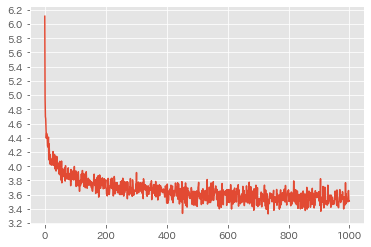

In [14]:
hidden_size = 256
embedding_dim = 256
model = LSTMPredictor(data.n_words, embedding_dim, hidden_size).to(device)

trainIters(model, 100000, print_every=10)

In [19]:
evaluateRandomly(model, 10)

outputs = evaluate(model, "だが 「 市場 の 論理 」 万能 の グローバル 化 は どう か 。")

> 米  軍  は  それ  に  対抗  し  て  世論  の  支持  を  得る  ため  に  記者  を  同行  さ  せる  。  
米:
['', '大リーグ', '軍', '英', '朝']
軍:
['大リーグ', '軍', '政府', '大統領', '米']
は:
['', '委員', '長', 'による', 'に対する']
それ:
['は', 'の', 'が', 'を', 'による']
に:
['', '同日', '前年', '既に', '未定']
対抗:
['１', '３', '２', '８', '「']
し:
['', 'まで', 'と', 'を', 'だけ']
て:
['を', 'に', 'が', 'も', 'の']
世論:
['', 'つながっ', 'いる', 'い', '「']
の:
['も', 'は', 'なっ', 'なる', '、']
支持:
['', 'れ', 'れる', 'ず', '感']
を:
['。', 'れ', '、', 'と', 'に']
得る:
['', '、', 'なけれ', 'たら', 'たく']
ため:
['て', '、', 'ない', 'たい', 'ながら']
に:
['', 'ほしい', 'い', 'き', 'いく']
記者:
['いる', 'い', 'き', 'しまう', 'は']
を:
['', 'う', 'ば', 'なっ', 'する']
同行:
['に', '。', 'の', 'から', 'を']
さ:
['', 'ため', 'よう', 'まま', '「']
せる:
['よう', 'ため', 'ない', 'ある', '一']
。:
['', '層', '者', 'さ', '率']
> 韓国  にとって  朝鮮  戦争  を  起こし  た  金  主席  は  、  許さ  れ  ない  「  敵  」  だっ  た  。  
韓国:
['の', '政府', '側', 'と', '先']
にとって:
['は', 'の', 'に', 'が', 'と']
朝鮮:
['', 'は', '、', '「', 'も']
戦争:
['も', 'の', '「', 'が', 'に']
を:
['', 'ず', '官', '「', 'が']
起こし:
['に', 'は', 'が', 'を', 'の']
た:
['', 

In [20]:
torch.save(model.state_dict(), "./weights/word_level.h5")